# Forward simulation of GPR signals over temperate ice


This notebook reproduce results of Ogier et al "Ground penetrating radar in temperate ice: distribution and size of englacial water inclusions as limiting factors." (in prep)


MORE INTRODUCTION needed here

In [48]:
#import
from math import sqrt
import os
import pandas


**Warning**: be careful with (hiden) open files. This may lead to error when running the code.

# Define and plot the builtin waveform: example for 25MHz

In the ``tools`` sub-package is a module called ``plot_source_wave`` which can be used to plot any of the builtin waveforms in time and frequency domains. The module takes the following arguments:

* ``type`` is the type of the waveform, e.g. ricker
* ``amp`` is the amplitude of the waveform
* ``freq`` is the centre frequency of the waveform
* ``timewindow`` is the time window used to view the waveform, i.e. the time window of the proposed simulation
* ``dt`` is the time step used to view the waveform, i.e. the time step of the proposed simulation

There is an optional argument:

* ``-fft`` a switch to turn on the FFT plotting for a single field component or current

For example (to use the module outside this notebook) to plot a Ricker waveform (and FFT) with an amplitude of 1, centre frequency of 25MHz and with a time window of 150ns and time step of 3.2ns:

    python -m tools.plot_source_wave ricker 1 25e6 3e-9 3.2e-9 -fft

Waveform characteristics...
Type: ricker
Maximum (absolute) amplitude: 0.980419
Centre frequency: 2.5e+07 Hz
Time to centre of pulse: 5.65685e-08 s
Time window: 1.5e-07 s (48 iterations)
Time step: 3.2e-09 s


/home/cogier/miniconda3/envs/gprMax/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


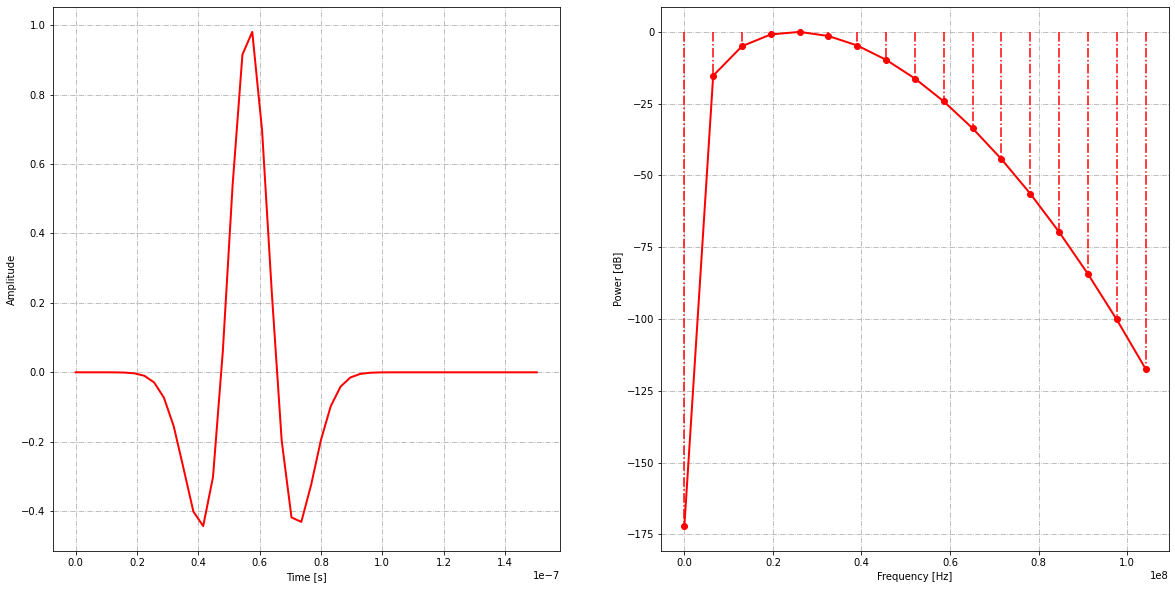

In [37]:
%matplotlib inline
from gprMax.waveforms import Waveform
from tools.plot_source_wave import check_timewindow, mpl_plot

w = Waveform()
w.type = 'ricker'
w.amp = 1
w.freq = 25e6
timewindow = 150e-9
dt = 3.2e-9

timewindow, iterations = check_timewindow(timewindow, dt)
plt = mpl_plot(w, timewindow, dt, iterations, fft=True)

# Determining a suitable spatial model resolution

In [3]:
# Speed of light in vacuum (m/s)
c = 299792458

# Highest relative permittivity present in model
er = 80 #that is water

# Maximum frequency present in model
fmax = 75e6 #3 times the central frequency

# Minimum wavelength
wmin = c / (fmax * sqrt(er))

# Maximum spatial resolution (allowing 10 cells per wavelength)
dmin = wmin / 10
dmin=0.5
# Time steps at CFL limits for cubic cells
dt3D = dmin / (sqrt(3) * c)
dt2D = dmin / (sqrt(2) * c)

print('Minimum wavelength: {:g} m'.format(wmin))
print('Maximum spatial resolution: {:g} m'.format(dmin))
print('Time step for 3D cubic cell: {:g} s'.format(dt3D))
print('Time step for 2D square cell: {:g} s'.format(dt2D))

Minimum wavelength: 0.446904 m
Maximum spatial resolution: 0.5 m
Time step for 3D cubic cell: 9.62917e-10 s
Time step for 2D square cell: 1.17933e-09 s


The time step required for the model is automatically calculated using the CFL condition (for this case in 2D).

# Define time windows

In [5]:
d = 105 #depth of the glacier model
er=3.2 #relative permittivity of ice
t = (2 * d) / (c / sqrt(er))
print('Minimum time window: {:g} s'.format(t))

Minimum time window: 1.25306e-06 s


# Define dielectrical properties of snow (optional)

Snow is not a pre-defined matierial in gprMax, and its conductivity depends of its density and water content.

We calculate the di-electric permittivity of wet snow according to Tiuri et al (1984). See also equations (2) and (3) of Griessinger et al (2018). $\epsilon_d$ is the real part of the complex dielectric permittivity of the dry snow, $\epsilon_s$ is the real part of the complex dielectric permittivity of the wet snow, $\epsilon_w$ is the permittivity of the water, $\theta$ is the liquid water content (LWC) and $\rho$ is the dry snow density

$$ \epsilon_d = 1 +1.7\rho + 0.7\rho^2$$
$$ \epsilon_s = (0.1 \theta + 0.8\theta^2)\epsilon_w + \epsilon_d $$ 

In [6]:
#permittivity of wet snow
rho = 0.5 
lwc = 0.03 # %
ew = 80 
ed=1 + 1.7*rho + 0.7*rho**2
es=(0.1*lwc + 0.8*lwc**2)*ew + ed
print('permittivity of dry snow is',ed)
print('permittivity of wet snow is',es)

permittivity of dry snow is 2.025
permittivity of wet snow is 2.3226


The conductivity is calculated from the formula of Gralund et al 2010:
$$ \sigma \approx  10 + 3.10^3 \times \theta $$
Here $\sigma$ is in $\mu S/m$

In [7]:
#conductivity of wet snow
sig=(10 + 3e3*lwc)/1e6 #conductivity in S/m
print('conductivity of wet snow is',sig,'S/m')

conductivity of wet snow is 0.0001 S/m


# Write `.in` files for gprMax

We created the model space in 2D (our "glacier box") with Matlab `glacier_model.m` (See GitHub repository `gpr_in_temperate_ice`).

Below we now write the `.in` file (input for gprMax) using functions in `../gprMax/input_cmd_funcs.py`.

This file set the gpr simulation frame (time space and discretization, materials, frquency...).



See [gprMax doc about building environment](http://docs.gprmax.com/en/latest/examples_simple_2D.html)

In [ ]:
#path
direname="../../../gprMax_data/2D_models/" 

In [480]:
#call function input_cmd_funcs.py
from gprMax.input_cmd_funcs import *
# read 'simulations.m' output attributes (parameters values of the matlab models)
models = pandas.read_csv(direname+'models_attributes.txt', sep='\s+', names=['id', 'LWC', 'smax'])
models

,id,LWC,smax
0,1,0.6,0.1
1,2,0.6,0.5
2,3,0.6,1.0
3,4,0.8,0.1
4,5,0.8,0.5
5,6,0.8,1.0
6,7,1.0,0.1
7,8,1.0,0.5
8,9,1.0,1.0


**Note: str(domain(x, y, z)) is the same than '#domain: ' + str(x) + str(y) + str(z)**

### Define constant model parameters (= the same for all simulations)

In [113]:
## Constant model parameters

# Model space discretization in m: See Maximum spatial resolution calculation above
dx=0.05;dy=0.05;dz=0.05

# Model space domain in m
x=100;y=110;z=dz #2D

# Time window in s (see Time window calculation above)
t_window = 1200e-9

# Wave form
shape='ricker';amplitude=1;identifier='my_ricker' #frequency is a free parameter
polarisation='z';x_source=1;y_source=105;z_source=0 #source coordinates

# Initial receiver position 
yr=y_source;zr=z_source #xr is defined later wuth frequency because receiver and transmitter distance equal one wave length

# Source-transmiteur steps (= trace spacing)
dx_source=0.5 #in m

### Create filenames list (based on the free parameters values: LWC, water inclusions size and frequency)

In [577]:
#create filename list
filename=[] #base name of the file (without .in)
infile=[] #base name with .in -> infile
fname=[] #total path with infile
freq=[25e6,100e6] #GPR frequency in Hz

for j in freq:
    for i in range(0,len(models)):

        filename += ['LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])
              +'_freq'+str(round(j/1000000))+"MHz"]
        infile += ['LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])
              +'_freq'+str(round(j/1000000))+"MHz"+'.in']
        fname += [direname+'LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])
              +'_freq'+str(round(j/1000000))+"MHz"+'.in']

fname


['../../../gprMax_data/2D_models/LWC0.6_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.1_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.5_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax1.0_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.1_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.5_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax1.0_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.1_f

## Write input files

In [581]:
fname


['../../../gprMax_data/2D_models/LWC0.6_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.1_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.5_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax1.0_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.1_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.5_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax1.0_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.1_f

In [578]:
freq

[25000000.0, 100000000.0]

In [584]:
for j in freq:
    for i in range(0,len(models)):

        title='LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])+'_freq'+str(round(j/1000000))+"MHz"   #title
        f = open(direname+'LWC'+str(models['LWC'][i])+'_smax'+str(models['smax'][i])
              +'_freq'+str(round(j/1000000))+"MHz"+'.in','w+')
        f.write(
        
            '#title: '+title+'\n'+
            '#domain: '+ str(domain(x, y, z))+'\n'+
            '#dx_dy_dz: '+ str(dx_dy_dz(dx, dy, dz))+'\n'+
            '#time_window: '+ str(t_window)+'\n'+
            '#waveform: '+ str(shape)+" "+str(amplitude)+" "+str(j)+" "+str(identifier)+'\n'+
            '#hertzian_dipole: '+ str(polarisation)+" "+str(x_source)+" "+str(y_source)+" "+str(z_source)
            +" "+str(identifier)+'\n'+
            'rx: '+str(x_source+1e8/j)+" "+str(yr)+" "+str(zr)+"\n"
            'src_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
            'rx_steps: '+str(dx_source)+" "+str(0)+" "+str(0)+"\n"
            'geometry_objects_read: '+ str(0)+" "+str(0)+" "+str(0)+" "+'../../../gprMax_data/2D_models/'+'LWC='+str(models['LWC'][i])+'-smax='+str(models['smax'][i])+'.h5'+" "+'../../../gprMax_data/2D_models/'+'LWC='+str(models['LWC'][i])+'-smax='+str(models['smax'][i])+'_material.txt'+"\n"+
            'geometry_view: '+str(0)+" "+str(0)+" "+str(0)+" "+str(x) +" "+str(y) +" "+str(z) +" "+str(dx) +" "+str(dy) +" "+str(dz)+" "+title+" "+'n'
            )
    
        f.close
    

#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05
#domain: 100 110 0.05
#dx_dy_dz: 0.05 0.05 0.05


# Run the model

# In CONSTRUCTION :)

To run the model to create a B-scan you must pass an optional argument to specify the number of times the model should be run. In this case this is the number of A-scans (traces) that will comprise the B-scan. For a B-scan over a distance of 120mm with a step of 2mm that is 60 A-scans. In the terminal we would use: `python -m gprMax user_models/cylinder_Bscan_2D.in -n 60` but here we call the functionm `api`.

## Write python script

This will be then run from the terminal

In [585]:
f = open(direname+'simulations_run.py','w+')
f.write(
'from gprMax.gprMax import api'+'\n'
'filename ='+str(infile)+'\n'+
'''path = '/scratch-3/cogier/gprMax_data/2D_models/' '''+'\n'+

'for i in range(0,len(filename)):'+'\n'
    '''\
    api(path+filename[i],gpu=[0], n=190)


    '''       
)   

f.close()


In [586]:
fname

['../../../gprMax_data/2D_models/LWC0.6_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.1_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.5_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax1.0_freq25MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.1_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax0.5_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.6_smax1.0_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.1_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax0.5_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC0.8_smax1.0_freq100MHz.in',
 '../../../gprMax_data/2D_models/LWC1.0_smax0.1_f

## Ready! Go to your terminal and run `$ python gprMax_data/2D_models/simulations_run.py` 

In [ ]:
## WARNING: check that `path` defined above matches you terminal path

## To be RESOLVED NOW: how to call gpu argument from terminal with api ?

In [372]:
#this works: (but without gpu running suprinsingly)(this works WITH gpu in terminal though....)
%run -m gprMax ../../../gprMax_data/2D_models/LWC0.6_smax0.5_freq25MHz.in -n 190 -gpu


=== Electromagnetic modelling software based on the Finite-Difference Time-Domain (FDTD) method 

    www.gprmax.com   __  __
     __ _ _ __  _ __|  \/  | __ ___  __
    / _` | '_ \| '__| |\/| |/ _` \ \/ /
   | (_| | |_) | |  | |  | | (_| |>  <
    \__, | .__/|_|  |_|  |_|\__,_/_/\_\
    |___/|_|
                     v3.1.6 (Big Smoke)

 Copyright (C) 2015-2022: The University of Edinburgh
 Authors: Craig Warren and Antonis Giannopoulos

 gprMax is free software: you can redistribute it and/or modify it under the
  terms of the GNU General Public License as published by the Free Software
  Foundation, either version 3 of the License, or (at your option) any later
  version.
 gprMax is distributed in the hope that it will be useful, but WITHOUT ANY
  WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR
  A PARTICULAR PURPOSE.  See the GNU General Public License for more details.
 You should have received a copy of the GNU General Public License along with
  gpr

KeyboardInterrupt: 

### Run simulations

In [343]:
#run the model
from gprMax.gprMax import api

#n=190 is the number of traces (refers to profile length divided by the source spacing)

for i in range(0,len(fname)):
    api(fname[i], n=190, gpu=True, geometry_only=False)
    
    #FAILS -> how to call the argument GPU ?

NameError: name 'gpu' is not defined

## View the results

### Merge A-scans into B-scan

You should have produced 60 output files, one for each A-scan, with names ``my_cylinder_Bscan_2D1.out``, ``my_cylinder_Bscan_2D2.out`` etc... These can be combined into a single file using the command:

    python -m tools.outputfiles_merge user_models/cylinder_Bscan_2D

In [14]:
from tools.outputfiles_merge import merge_files
merge_files(basename, removefiles=False)

You should see a combined output file ``basename_merged.out``. Delete the original single A-scan output files or keep them with the argument.

### Plot the B-scan

You can plot the B-scan using:

    python -m tools.plot_Bscan user_models/cylinder_Bscan_2D_merged.out Ez

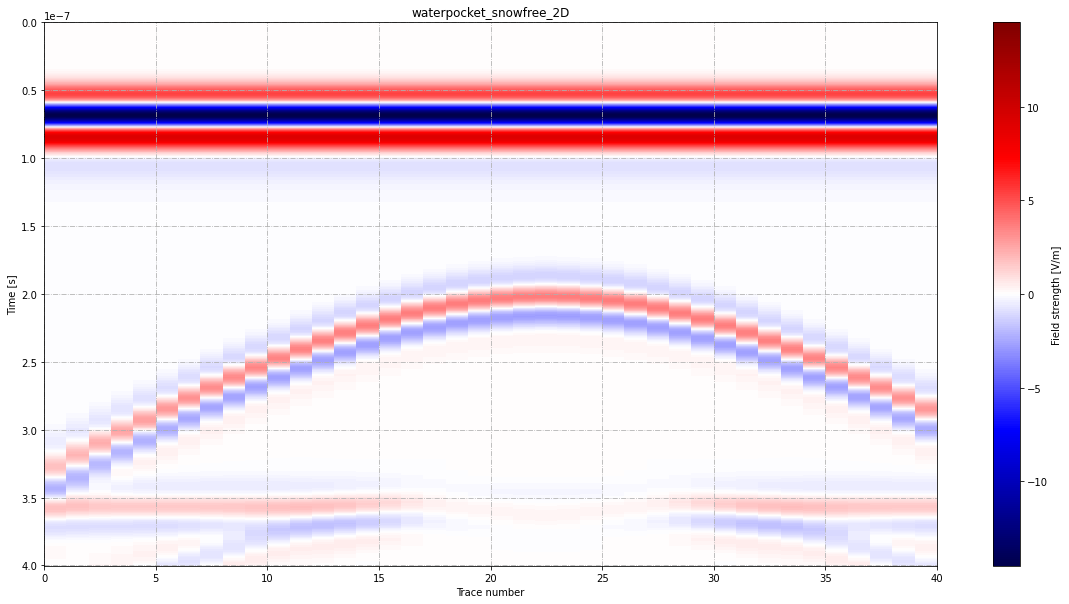

In [15]:
%matplotlib inline
import os
from tools.plot_Bscan import get_output_data, mpl_plot

outputname = basename+'_merged.out' #output file path
rxnumber = 1
rxcomponent = 'Ez'
outputdata, dt = get_output_data(outputname, rxnumber, rxcomponent)
plt = mpl_plot(outputname,outputdata, dt, rxnumber, rxcomponent)
plt.title(file)
plt.savefig(basename+'_plot.png')
# Change from the default 'seismic' colormap
#plt.set_cmap('gray')

The B-scan (of the $E_z$ field component) shows the initial part of the signal (~0.5-1.5 ns) which represents the direct wave from transmitter to receiver. Then comes the refelected wave (~2-3 ns) from the metal cylinder which creates the hyperbolic shape.